In [12]:
!pip install matplotlib

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/5c/98/211647fc6aa89355c11b028f37ceae95d7e1bbb99ac363cbf4c4297ef4d7/matplotlib-3.8.2-cp39-cp39-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/8a/b8/258adec810e0c4c28292ad1af5736809d393587bd88e79635343fcdc78d0/contourpy-1.2.0-cp39-cp39-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/2b/ff/8c9b05fd2bbdfe6fee7c0e8a3e8981b4454404dca3ef58fc98a6673a6cf8/fonttools-4.46.0-cp39-cp39-macosx_10_9_universal2.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.2/156.2 kB 4.6 MB/s eta 0:00:00
  Obtaining dependency information for

In [15]:
from matplotlib import pyplot as plt
from rcpm import dataset
from rcpm import utils
from rcpm import eval

from pathlib import Path

import os

In [2]:
raw_data_folder = Path('/data')
cropped_image_dir = raw_data_folder / 'cropped_data'
split_file_dir = utils.file_abs_path(os.getcwd()) / '_test/files/wp_reid_info.json'

In [3]:
wp_reid_dataset = dataset.DataBank(
    minframes=3,
    raw_data_folder=raw_data_folder,
    cropped_image_dir=cropped_image_dir,
    split_file_dir=split_file_dir
)

Load data <--- /Users/jangsoopark/Documents/course/2023/fall/internet-of-things/WP-ReID/_test/files/wp_reid_info.json
WPReID dataset
Gallery ID diff Probe ID: []

+--------+--------+-------+---------+
|  Raw   |  Test  | Probe | Gallery |
+--------+--------+-------+---------+
|  #ID   |   79   |   79  |    79   |
| #Track |  868   |  239  |   868   |
| #Image | 106578 | 33345 |  106578 |
|  #Cam  |   6    |   6   |    6    |
| MaxLen |  1165  |  1165 |   1165  |
| MinLen |   3    |   3   |    3    |
| AvgLen |  122   |  139  |   122   |
+--------+--------+-------+---------+
After drop videos less than: test  3 frames, check cam number
No related gallery track with different camera id. Drop probe [   33     3 96929 97207   278]
No related gallery track with different camera id. Drop probe [   34     3 97207 97258    51]
No related gallery track with different camera id. Drop probe [   36     3 97342 97522   180]
No related gallery track with different camera id. Drop probe [   37     3 

In [4]:
files_dir = utils.file_abs_path(os.getcwd()) / '_test/files'

mmt_duke_dist_file = files_dir / 'mmt_duke_g2g_distmat.json'

In [5]:
import copy
from rcpm import update_module 
from rcpm import video_reid_performance
from rcpm import eval_tools
# import get_vision_record_dist, visual_affinity_update, trajectory_distance_update, norm_data

class AblationRecurrentContextPropagationModule(eval.RecurrentContextPropagationModule):

    def rcpm(self, gt_dist_new, iteration=1):
        distMat_new = update_module.visual_affinity_update(
            self.raw_distMat, 
            gt_dist=gt_dist_new.copy(), 
            T=self.delta, 
            alpha=self.alpha
        )
        cmc_reid, mAP_reid = video_reid_performance.compute_video_cmc_map(
            distMat_new[self.query_index][:, self.gallery_index], 
            self.query_id, self.gallery_id,
            self.query_cam_id, 
            self.gallery_cam_id
        )
        gt_dist_new = update_module.trajectory_distance_update(
            distMat_new, 
            self.raw_gt_dist.copy(), 
            k=self.k
        )
        cmc_SM = eval_tools.get_signal_match_cmc(
            gt_dist_new[self.query_index].copy(), 
            self.gt_dist_is_inf[self.query_index].copy(),
            self.query_id.copy(), 
            self.traj_id.copy()
        )
        
        return gt_dist_new, cmc_reid, mAP_reid, cmc_SM
        
    def __call__(self, *args, **kwargs):
        print('K={}, Delta={}, Iteration={}'.format(self.k, self.delta, self.iters))
        cmc_reid, mAP_reid = video_reid_performance.compute_video_cmc_map(
            self.raw_distMat[self.query_index][:, self.gallery_index], 
            self.query_id, self.gallery_id,
            self.query_cam_id, 
            self.gallery_cam_id
        )
        cmc_SM = eval_tools.get_signal_match_cmc(
            self.raw_gt_dist[self.query_index].copy(), 
            self.gt_dist_is_inf[self.query_index].copy(),
            self.query_id.copy(), 
            self.traj_id.copy()
        )

        # print('Iteration {}: ReID rank-1 {:.2f} mAP {:.2f}. Signal Matching rank-1 {:.2f}'.format(
        #     0, cmc_reid[0] * 100, mAP_reid * 100, cmc_SM[0] * 100))
        
        last_gt_dist = self.raw_gt_dist
        history = {
            'cmc_reid': [],
            'mAP_reid': [],
            'cmc_SM': []
        }
        for i in range(self.iters):
            last_gt_dist, cmc_reid, mAP_reid, cmc_SM = self.rcpm(last_gt_dist, iteration=i+1)
            print('Iteration {}: ReID rank-1 {:.2f} mAP {:.2f}. Signal Matching rank-1 {:.2f}'.format(
                i + 1, cmc_reid[0] * 100, mAP_reid * 100, cmc_SM[0] * 100))
            history['cmc_reid'].append(cmc_reid[0] * 100)
            history['mAP_reid'].append(mAP_reid * 100)
            history['cmc_SM'].append(cmc_SM[0] * 100)

        return history


def ablation_update_with_gps(distMat, all_info, query_index, gallery_index, bndbox_gps, trajectory, k=9, delta=74, iters=5):
    '''
    :param distMat: (g, g), the distance between gallery tracklet with gallery tracklet
    :param all_info: (num, 5), num is the total number of gallery tracklet, each row [p_id, cam_id, idx, idx+frame_num, frame_num]
    :param query_index: the query index for query tracklet in gallery tracklet
    :param gallery_index: the gallery index for query tracklet in gallery tracklet
    :param bndbox_gps: (image_num, 3), each raw: [time_id, gps_j, gps_w]
    :param trajectory: dict, the key is the corresponding person id. trajectory[p_id] : (n, 3), each row [timestamp, gps_j, gps_w]
    :return:
    '''
    gallery_info = all_info[gallery_index]
    gt_gps_dist, traj_id = eval.get_vision_record_dist(gallery_info.copy(), bndbox_gps.copy(), copy.deepcopy(trajectory))
    rcpm = AblationRecurrentContextPropagationModule(k=k, delta=delta, iters=iters, distMat=distMat, gt_dist=gt_gps_dist, traj_id=traj_id)
    rcpm.init_dataset_info(all_info=all_info, query_index=query_index, gallery_index=gallery_index)
    
    return rcpm()

## Figure 5 (c) without RCPM$^*$

In [10]:
k = 8
sigma = 74
max_iters = 8

distmat = utils.DataPacker.load(mmt_duke_dist_file)['g2g_distmat']
history_iters = ablation_update_with_gps(
    distmat, 
    wp_reid_dataset.test_info, 
    wp_reid_dataset.probe_index, 
    wp_reid_dataset.gallery_index,
    wp_reid_dataset.gps_info, 
    wp_reid_dataset.trajectory_info, 
    k=k,
    delta=sigma,
    iters=max_iters
)

# print(cmc_reid, mAP_reid, cmc_SM)

Load data <--- /Users/jangsoopark/Documents/course/2023/fall/internet-of-things/WP-ReID/_test/files/mmt_duke_g2g_distmat.json
K=8, Delta=74, Iteration=8
Iteration 1: ReID rank-1 73.13 mAP 49.14. Signal Matching rank-1 81.71
Iteration 2: ReID rank-1 75.62 mAP 59.09. Signal Matching rank-1 84.15
Iteration 3: ReID rank-1 76.12 mAP 60.87. Signal Matching rank-1 86.59
Iteration 4: ReID rank-1 77.61 mAP 61.47. Signal Matching rank-1 84.76
Iteration 5: ReID rank-1 77.11 mAP 61.02. Signal Matching rank-1 86.59
Iteration 6: ReID rank-1 78.11 mAP 61.41. Signal Matching rank-1 86.59
Iteration 7: ReID rank-1 77.11 mAP 61.30. Signal Matching rank-1 86.59
Iteration 8: ReID rank-1 76.62 mAP 61.40. Signal Matching rank-1 86.59


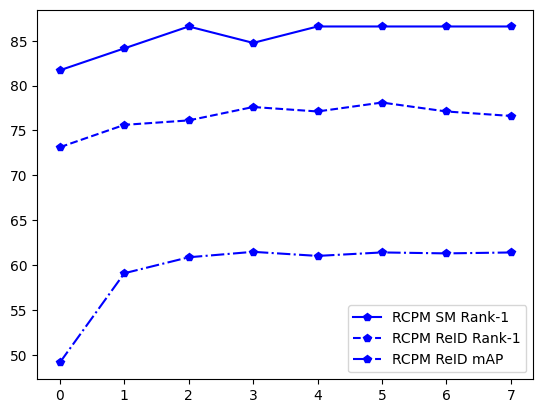

In [22]:
plt.plot(list(range(8)), history_iters['cmc_SM'], '-p', color='blue', label='RCPM SM Rank-1')
plt.plot(list(range(8)), history_iters['cmc_reid'], '--p', color='blue', label='RCPM ReID Rank-1')
plt.plot(list(range(8)), history_iters['mAP_reid'], '-.p', color='blue', label='RCPM ReID mAP')

plt.legend()

## Figure 5 (a)

In [45]:
# k = 8
sigma = 74
max_iters = 4

distmat = utils.DataPacker.load(mmt_duke_dist_file)['g2g_distmat']

history_k = {
    'cmc_reid': [],
    'mAP_reid': [],
    'cmc_SM': []
}
for k in range(1, 20):
    
    history = ablation_update_with_gps(
        distmat, 
        wp_reid_dataset.test_info, 
        wp_reid_dataset.probe_index, 
        wp_reid_dataset.gallery_index,
        wp_reid_dataset.gps_info, 
        wp_reid_dataset.trajectory_info, 
        k=k,
        delta=sigma,
        iters=max_iters
    )

    history_k['cmc_reid'].append(history['cmc_reid'][-1])
    history_k['mAP_reid'].append(history['mAP_reid'][-1])
    history_k['cmc_SM'].append(history['cmc_SM'][-1])

# print(cmc_reid, mAP_reid, cmc_SM)

Load data <--- /Users/jangsoopark/Documents/course/2023/fall/internet-of-things/WP-ReID/_test/files/mmt_duke_g2g_distmat.json
K=1, Delta=74, Iteration=4
Iteration 1: ReID rank-1 73.13 mAP 49.14. Signal Matching rank-1 53.66
Iteration 2: ReID rank-1 73.13 mAP 49.14. Signal Matching rank-1 53.66
Iteration 3: ReID rank-1 73.13 mAP 49.14. Signal Matching rank-1 53.66
Iteration 4: ReID rank-1 73.13 mAP 49.14. Signal Matching rank-1 53.66
K=2, Delta=74, Iteration=4
Iteration 1: ReID rank-1 73.13 mAP 49.14. Signal Matching rank-1 67.07
Iteration 2: ReID rank-1 74.13 mAP 54.37. Signal Matching rank-1 69.51
Iteration 3: ReID rank-1 73.63 mAP 54.81. Signal Matching rank-1 70.12
Iteration 4: ReID rank-1 73.63 mAP 54.78. Signal Matching rank-1 70.12
K=3, Delta=74, Iteration=4
Iteration 1: ReID rank-1 73.13 mAP 49.14. Signal Matching rank-1 77.44
Iteration 2: ReID rank-1 75.12 mAP 58.23. Signal Matching rank-1 78.05
Iteration 3: ReID rank-1 76.12 mAP 58.21. Signal Matching rank-1 78.05
Iteration 4:

In [30]:
len(history_k['cmc_SM']), len(list(range(max_iters - 1)))

(19, 3)

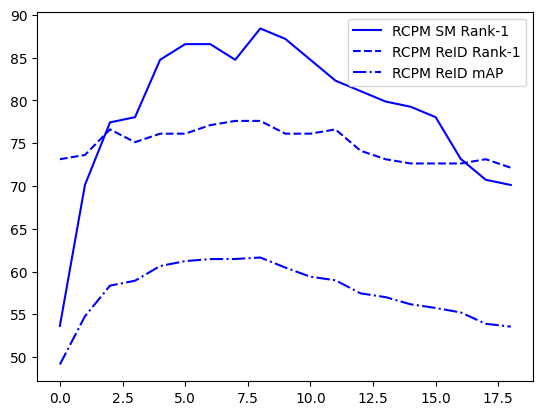

In [31]:
plt.plot(list(range(19)), history_k['cmc_SM'], '-', color='blue', label='RCPM SM Rank-1')
plt.plot(list(range(19)), history_k['cmc_reid'], '--', color='blue', label='RCPM ReID Rank-1')
plt.plot(list(range(19)), history_k['mAP_reid'], '-.', color='blue', label='RCPM ReID mAP')

plt.legend()

## Figure 5 (b)

In [32]:
k = 8
# sigma = 74
max_iters = 4

distmat = utils.DataPacker.load(mmt_duke_dist_file)['g2g_distmat']

history_sigma = {
    'cmc_reid': [],
    'mAP_reid': [],
    'cmc_SM': []
}
for sigma in range(1, 141):
    
    history = ablation_update_with_gps(
        distmat, 
        wp_reid_dataset.test_info, 
        wp_reid_dataset.probe_index, 
        wp_reid_dataset.gallery_index,
        wp_reid_dataset.gps_info, 
        wp_reid_dataset.trajectory_info, 
        k=k,
        delta=sigma,
        iters=max_iters
    )

    history_sigma['cmc_reid'].append(history['cmc_reid'][-1])
    history_sigma['mAP_reid'].append(history['mAP_reid'][-1])
    history_sigma['cmc_SM'].append(history['cmc_SM'][-1])

# print(cmc_reid, mAP_reid, cmc_SM)

Load data <--- /Users/jangsoopark/Documents/course/2023/fall/internet-of-things/WP-ReID/_test/files/mmt_duke_g2g_distmat.json
K=8, Delta=1, Iteration=4
Iteration 1: ReID rank-1 73.13 mAP 37.82. Signal Matching rank-1 70.12
Iteration 2: ReID rank-1 73.13 mAP 37.82. Signal Matching rank-1 70.12
Iteration 3: ReID rank-1 73.13 mAP 37.82. Signal Matching rank-1 70.12
Iteration 4: ReID rank-1 73.13 mAP 37.82. Signal Matching rank-1 70.12
K=8, Delta=2, Iteration=4
Iteration 1: ReID rank-1 73.13 mAP 37.82. Signal Matching rank-1 70.12
Iteration 2: ReID rank-1 73.13 mAP 37.82. Signal Matching rank-1 70.12
Iteration 3: ReID rank-1 73.13 mAP 37.82. Signal Matching rank-1 70.12
Iteration 4: ReID rank-1 73.13 mAP 37.82. Signal Matching rank-1 70.12
K=8, Delta=3, Iteration=4
Iteration 1: ReID rank-1 73.13 mAP 37.78. Signal Matching rank-1 70.12
Iteration 2: ReID rank-1 73.13 mAP 37.82. Signal Matching rank-1 70.12
Iteration 3: ReID rank-1 73.13 mAP 37.82. Signal Matching rank-1 70.12
Iteration 4: Re

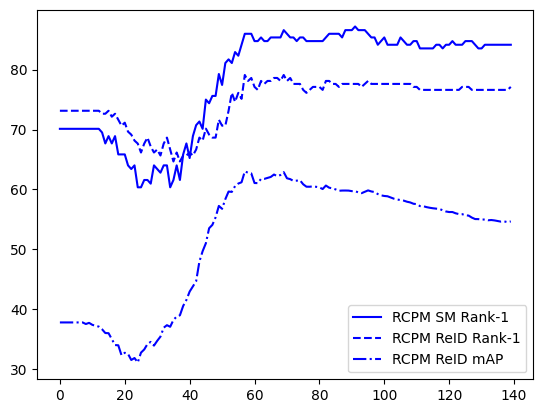

In [33]:
plt.plot(list(range(140)), history_sigma['cmc_SM'], '-', color='blue', label='RCPM SM Rank-1')
plt.plot(list(range(140)), history_sigma['cmc_reid'], '--', color='blue', label='RCPM ReID Rank-1')
plt.plot(list(range(140)), history_sigma['mAP_reid'], '-.', color='blue', label='RCPM ReID mAP')

plt.legend()

## Figure 5(c) with RCPM$^*$

In [80]:
import copy
from rcpm import update_module 
from rcpm import video_reid_performance
from rcpm import eval_tools
# import get_vision_record_dist, visual_affinity_update, trajectory_distance_update, norm_data

class Ablation2RecurrentContextPropagationModule(eval.RecurrentContextPropagationModule):

    def rcpm(self, distMat_new, gt_dist_new, iteration=1):
        print(distMat_new.max(), distMat_new.min())
        distMat_new = update_module.visual_affinity_update(
            # distMat_new,
            update_module.norm_data(distMat_new),
            gt_dist=gt_dist_new.copy(), 
            T=self.delta, 
            alpha=self.alpha
        )
        
        cmc_reid, mAP_reid = video_reid_performance.compute_video_cmc_map(
            distMat_new[self.query_index][:, self.gallery_index], 
            self.query_id, self.gallery_id,
            self.query_cam_id, 
            self.gallery_cam_id
        )
        gt_dist_new = update_module.trajectory_distance_update(
            distMat_new, 
            self.raw_gt_dist.copy(), 
            k=self.k
        )
        cmc_SM = eval_tools.get_signal_match_cmc(
            gt_dist_new[self.query_index].copy(), 
            self.gt_dist_is_inf[self.query_index].copy(),
            self.query_id.copy(), 
            self.traj_id.copy()
        )
        
        return distMat_new, gt_dist_new, cmc_reid, mAP_reid, cmc_SM
        
    def __call__(self, *args, **kwargs):
        print('K={}, Delta={}, Iteration={}'.format(self.k, self.delta, self.iters))
        cmc_reid, mAP_reid = video_reid_performance.compute_video_cmc_map(
            self.raw_distMat[self.query_index][:, self.gallery_index], 
            self.query_id, self.gallery_id,
            self.query_cam_id, 
            self.gallery_cam_id
        )
        cmc_SM = eval_tools.get_signal_match_cmc(
            self.raw_gt_dist[self.query_index].copy(), 
            self.gt_dist_is_inf[self.query_index].copy(),
            self.query_id.copy(), 
            self.traj_id.copy()
        )

        # print('Iteration {}: ReID rank-1 {:.2f} mAP {:.2f}. Signal Matching rank-1 {:.2f}'.format(
        #     0, cmc_reid[0] * 100, mAP_reid * 100, cmc_SM[0] * 100))

        last_distMat = self.raw_distMat
        last_gt_dist = self.raw_gt_dist
        history = {
            'cmc_reid': [],
            'mAP_reid': [],
            'cmc_SM': []
        }
        for i in range(self.iters):
            last_distMat, last_gt_dist, cmc_reid, mAP_reid, cmc_SM = self.rcpm(last_distMat, last_gt_dist, iteration=i+1)
            print('Iteration {}: ReID rank-1 {:.2f} mAP {:.2f}. Signal Matching rank-1 {:.2f}'.format(
                i + 1, cmc_reid[0] * 100, mAP_reid * 100, cmc_SM[0] * 100))
            history['cmc_reid'].append(cmc_reid[0] * 100)
            history['mAP_reid'].append(mAP_reid * 100)
            history['cmc_SM'].append(cmc_SM[0] * 100)

        return history


def ablation2_update_with_gps(distMat, all_info, query_index, gallery_index, bndbox_gps, trajectory, k=9, delta=74, iters=5):
    '''
    :param distMat: (g, g), the distance between gallery tracklet with gallery tracklet
    :param all_info: (num, 5), num is the total number of gallery tracklet, each row [p_id, cam_id, idx, idx+frame_num, frame_num]
    :param query_index: the query index for query tracklet in gallery tracklet
    :param gallery_index: the gallery index for query tracklet in gallery tracklet
    :param bndbox_gps: (image_num, 3), each raw: [time_id, gps_j, gps_w]
    :param trajectory: dict, the key is the corresponding person id. trajectory[p_id] : (n, 3), each row [timestamp, gps_j, gps_w]
    :return:
    '''
    gallery_info = all_info[gallery_index]
    gt_gps_dist, traj_id = eval.get_vision_record_dist(gallery_info.copy(), bndbox_gps.copy(), copy.deepcopy(trajectory))
    rcpm = Ablation2RecurrentContextPropagationModule(k=k, delta=delta, iters=iters, distMat=distMat, gt_dist=gt_gps_dist, traj_id=traj_id)
    rcpm.init_dataset_info(all_info=all_info, query_index=query_index, gallery_index=gallery_index)
    
    return rcpm()

In [81]:
k = 8
sigma = 74
max_iters = 9

distmat = utils.DataPacker.load(mmt_duke_dist_file)['g2g_distmat']
history_iters = ablation_update_with_gps(
    distmat, 
    wp_reid_dataset.test_info, 
    wp_reid_dataset.probe_index, 
    wp_reid_dataset.gallery_index,
    wp_reid_dataset.gps_info, 
    wp_reid_dataset.trajectory_info, 
    k=k,
    delta=sigma,
    iters=max_iters
)

history2_iters = ablation2_update_with_gps(
    distmat, 
    wp_reid_dataset.test_info, 
    wp_reid_dataset.probe_index, 
    wp_reid_dataset.gallery_index,
    wp_reid_dataset.gps_info, 
    wp_reid_dataset.trajectory_info, 
    k=k,
    delta=sigma,
    iters=max_iters
)




Load data <--- /Users/jangsoopark/Documents/course/2023/fall/internet-of-things/WP-ReID/_test/files/mmt_duke_g2g_distmat.json
K=8, Delta=74, Iteration=9
Iteration 1: ReID rank-1 73.13 mAP 49.14. Signal Matching rank-1 81.71
Iteration 2: ReID rank-1 75.62 mAP 59.09. Signal Matching rank-1 84.15
Iteration 3: ReID rank-1 76.12 mAP 60.87. Signal Matching rank-1 86.59
Iteration 4: ReID rank-1 77.61 mAP 61.47. Signal Matching rank-1 84.76
Iteration 5: ReID rank-1 77.11 mAP 61.02. Signal Matching rank-1 86.59
Iteration 6: ReID rank-1 78.11 mAP 61.41. Signal Matching rank-1 86.59
Iteration 7: ReID rank-1 77.11 mAP 61.30. Signal Matching rank-1 86.59
Iteration 8: ReID rank-1 76.62 mAP 61.40. Signal Matching rank-1 86.59
Iteration 9: ReID rank-1 77.11 mAP 61.14. Signal Matching rank-1 86.59
K=8, Delta=74, Iteration=9
1.0 0.0
Iteration 1: ReID rank-1 73.13 mAP 49.14. Signal Matching rank-1 81.71
1.0 0.0
Iteration 2: ReID rank-1 72.64 mAP 59.55. Signal Matching rank-1 84.15
1.0 0.0
Iteration 3: Re

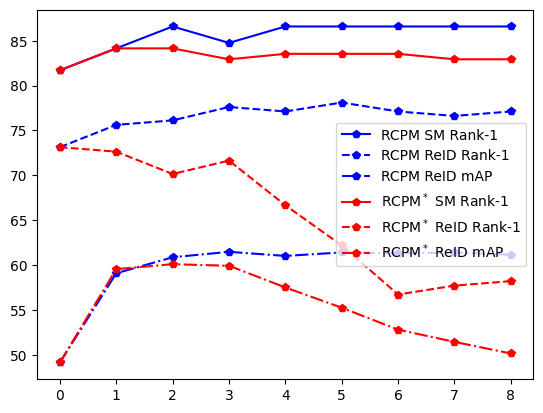

In [82]:
plt.plot(list(range(max_iters)), history_iters['cmc_SM'], '-p', color='blue', label='RCPM SM Rank-1')
plt.plot(list(range(max_iters)), history_iters['cmc_reid'], '--p', color='blue', label='RCPM ReID Rank-1')
plt.plot(list(range(max_iters)), history_iters['mAP_reid'], '-.p', color='blue', label='RCPM ReID mAP')

plt.plot(list(range(max_iters)), history2_iters['cmc_SM'], '-p', color='red', label='RCPM$^*$ SM Rank-1')
plt.plot(list(range(max_iters)), history2_iters['cmc_reid'], '--p', color='red', label='RCPM$^*$ ReID Rank-1')
plt.plot(list(range(max_iters)), history2_iters['mAP_reid'], '-.p', color='red', label='RCPM$^*$ ReID mAP')

plt.legend()

## Figure 5

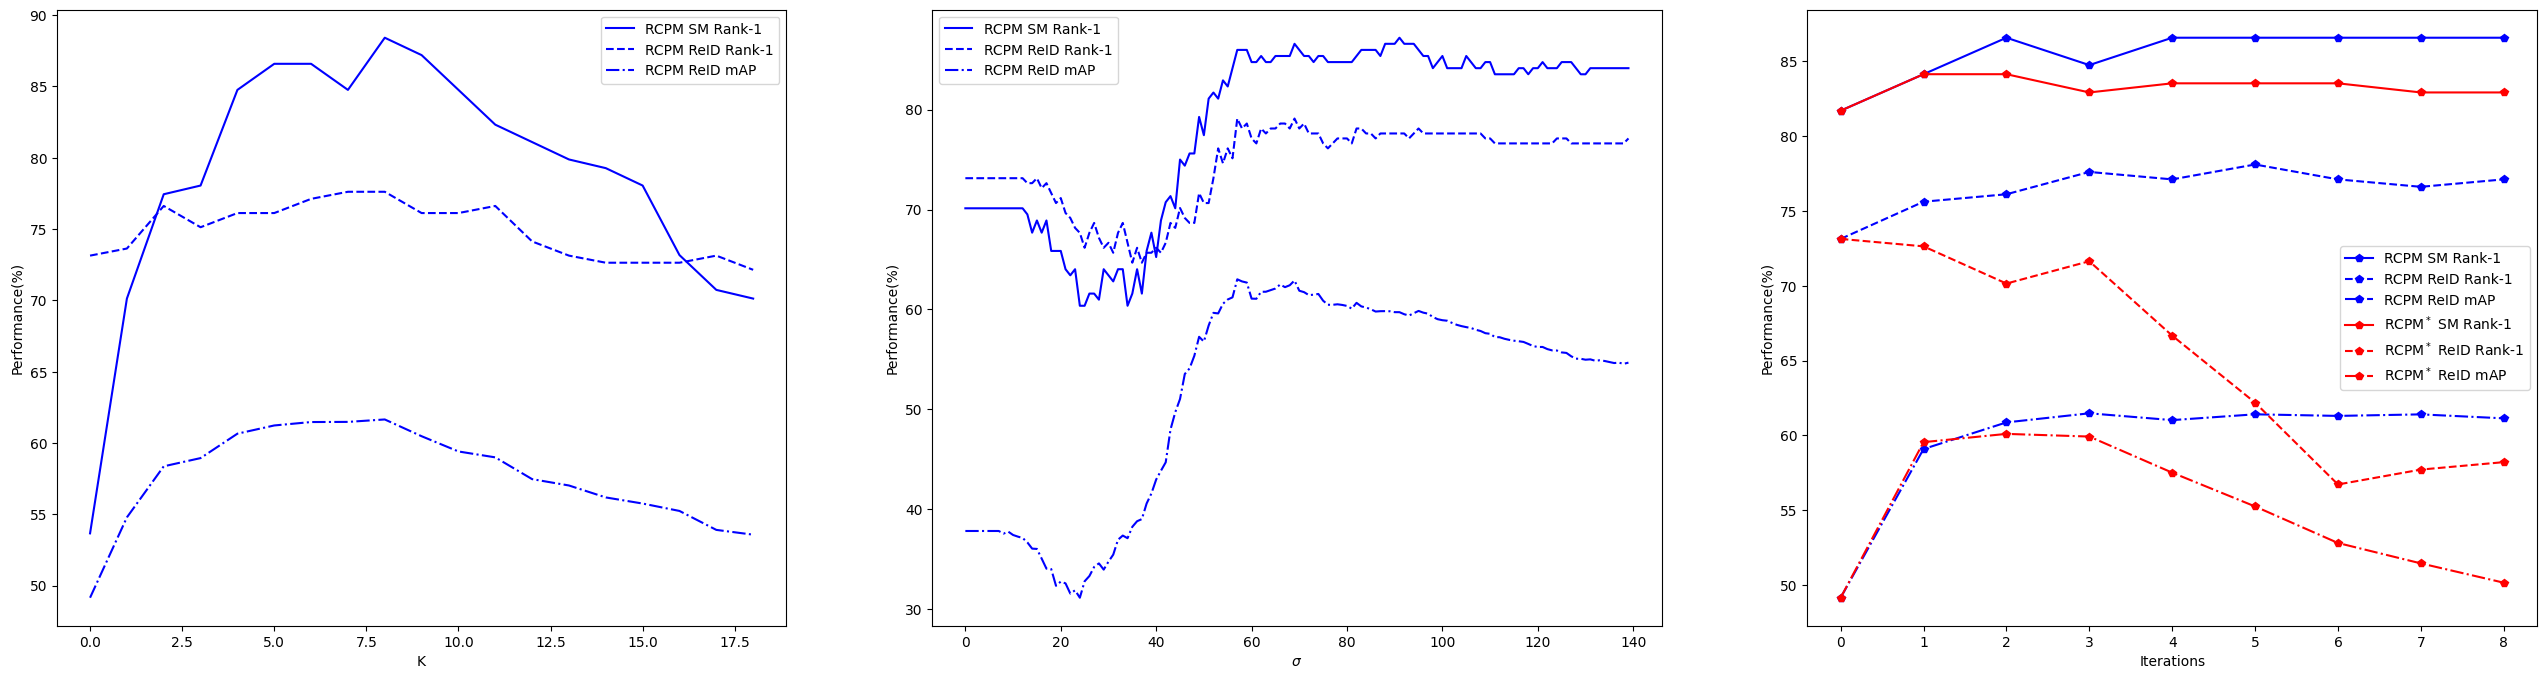

In [83]:
fig, axes = plt.subplots(1, 3, figsize=(32, 8))

# Figure 5 (a)
axes[0].plot(list(range(19)), history_k['cmc_SM'], '-', color='blue', label='RCPM SM Rank-1')
axes[0].plot(list(range(19)), history_k['cmc_reid'], '--', color='blue', label='RCPM ReID Rank-1')
axes[0].plot(list(range(19)), history_k['mAP_reid'], '-.', color='blue', label='RCPM ReID mAP')

axes[0].set_ylabel('Performance(%)')
axes[0].set_xlabel('K')
axes[0].legend()

# Figure 5 (b)
axes[1].plot(list(range(140)), history_sigma['cmc_SM'], '-', color='blue', label='RCPM SM Rank-1')
axes[1].plot(list(range(140)), history_sigma['cmc_reid'], '--', color='blue', label='RCPM ReID Rank-1')
axes[1].plot(list(range(140)), history_sigma['mAP_reid'], '-.', color='blue', label='RCPM ReID mAP')

axes[1].set_ylabel('Performance(%)')
axes[1].set_xlabel('$\sigma$')
axes[1].legend()

# Figure 5 (c) - RCPM
axes[2].plot(list(range(9)), history_iters['cmc_SM'], '-p', color='blue', label='RCPM SM Rank-1')
axes[2].plot(list(range(9)), history_iters['cmc_reid'], '--p', color='blue', label='RCPM ReID Rank-1')
axes[2].plot(list(range(9)), history_iters['mAP_reid'], '-.p', color='blue', label='RCPM ReID mAP')

# Figure 5 (c) - RCPM*
axes[2].plot(list(range(9)), history2_iters['cmc_SM'], '-p', color='red', label='RCPM$^*$ SM Rank-1')
axes[2].plot(list(range(9)), history2_iters['cmc_reid'], '--p', color='red', label='RCPM$^*$ ReID Rank-1')
axes[2].plot(list(range(9)), history2_iters['mAP_reid'], '-.p', color='red', label='RCPM$^*$ ReID mAP')

axes[2].set_ylabel('Performance(%)')
axes[2].set_xlabel('Iterations')
axes[2].legend()

